In [1]:
import numpy as np
import pandas as pd
import openpyxl
import math
import matplotlib.pyplot as plt

In [2]:
def f1(x,y):
    #Inputs for the problem
    initlen=0.01
    numberOfElements = 1400
    numberOfNodes = numberOfElements + 1
    nodesInElement = 2
    volumetricInjectionRate = 0.015
    aquiferLayerThickness = 20
    fluidHeatCapacity = 4000*1000
    n=0.25
    aquiferHeatCapacity = n*fluidHeatCapacity+(1-n)*2600*1040
    thermalConductivity = 2.2
    thermalDiffusivity = thermalConductivity / aquiferHeatCapacity
    upperHeatCapacity = 0.15*fluidHeatCapacity+(1-0.15)*2600*1040
    upperDiffusivity = thermalConductivity / upperHeatCapacity
    fCoeff = 0
    domainStartPoint = 0.25
    domainEndPoint = 0.25+(initlen+1)*numberOfElements/2
    tempAtDomainStartingPoint = 273.15+25.8 #r=r0
    tempAtDomainEndingPoint = 273.15+14.8 #r=infinite
    
    alpha=volumetricInjectionRate*fluidHeatCapacity/(4*np.pi*aquiferLayerThickness*thermalConductivity)
    #Create a vector to store solution considering the number of nodes and time domain given as input

    t_0=(aquiferLayerThickness**2)/(4*thermalDiffusivity)
    if y:
        lambda_star=2*t_0*thermalConductivity/(aquiferHeatCapacity*aquiferLayerThickness*math.sqrt(upperDiffusivity*t_0))
    else:
        lambda_star=0
    timeDomainInYears = x
    endOfTime = 60*60*24*360*timeDomainInYears
    timeStep = 60*60*24*360/52
    r_0=math.sqrt(fluidHeatCapacity/aquiferHeatCapacity*volumetricInjectionRate*endOfTime/(np.pi*aquiferLayerThickness))
    D_star=(aquiferLayerThickness**2)/(r_0**2)
    tempSolutionVector = np.zeros((numberOfNodes,int(endOfTime/timeStep))) #node数为行数，时间节点数量为列数
    #Create a vector for x-axis
    distanceVector = np.zeros((numberOfNodes,1))
    for i in range(0,1401):
        if i==0:
            distanceVector[i] = domainStartPoint/r_0
        else:
            distanceVector[i] = domainStartPoint/r_0+(initlen+(1-initlen)/(numberOfElements-1)*(i-1)+initlen)*(i)/2/r_0

    #Get the initial temperature profile for time =0
    #Initial temperature is T = 14.8 Celsius ever
    # ywhere in the domain
    #Injection temperature is given as 25.8 degrees
    tempSolutionVector[0,0] = 1
    for i in range(2,numberOfNodes+1):
        tempSolutionVector[i-1, 0] = 0

    #Initiate the local node to global node mapping matrix
    localToGlobal = np.zeros((numberOfElements,nodesInElement))
    #Create the local node to global node mapping matrix
    for outerLoop in range(0,numberOfElements):
        for innerLoop in range(0,nodesInElement-1):
            localToGlobal[outerLoop,innerLoop] = outerLoop+1
            localToGlobal[outerLoop,innerLoop+1] = outerLoop+2


    #Initiate the global stiffness matrix with a size of numberOfNodes x numberOfNodes
    globalStiffnessMatrix = np.zeros((numberOfNodes,numberOfNodes))
    #Initiate the global mass matrix with a size of numberOfNodes x numberOfNodes
    globalMassMatrix = np.zeros((numberOfNodes,numberOfNodes))
    #Initiate the global forcing vector
    globalForcingVector = np.zeros((numberOfNodes,1))
    #Calculation of the Jacobian
    #Je = (domainEndPoint-domainStartPoint)/r_0/numberOfElements/2
    #Calculation of the elemental mass matrix elements with two points Gauss Quadrature
    #For the Gauss Quadrature, first sample evaluation point is -1/sqrt(3) and second points is 1/sqrt(3)
    for elementCounter in range(0,numberOfElements):
    #Initiate the function evaluations for the shape function
        Je=((1-initlen)/(numberOfElements-1)*elementCounter+initlen)/r_0/2
        S_i_eval1 = 0
        S_i_eval2 = 0
        S_j_eval1 = 0
        S_j_eval2 = 0
        r_eval1 = 0
        r_eval2 = 0
        elememtCoordinate1 = (initlen+(1-initlen)/(numberOfElements-1)*(elementCounter-1)+initlen)*(elementCounter)/2/r_0
        elementCoordinate2 = (initlen+(1-initlen)/(numberOfElements-1)*elementCounter+initlen)*(elementCounter+1)/2/r_0
        r_eval1 = Je*-1/math.sqrt(3) + (elememtCoordinate1+elementCoordinate2)/2
        r_eval2 = Je*+1/math.sqrt(3) + (elememtCoordinate1+elementCoordinate2)/2
        for firstIndex in range(0, nodesInElement):
            for secondIndex in range(0, nodesInElement):
                if firstIndex == 0:
                    S_i_eval1 = 0.5*(1+1/math.sqrt(3))
                    S_i_eval2 = 0.5*(1-1/math.sqrt(3))
                if firstIndex == 1:
                    S_i_eval1 = 0.5*(1-1/math.sqrt(3))
                    S_i_eval2 = 0.5*(1+1/math.sqrt(3))
                if secondIndex == 0:
                    S_j_eval1 = 0.5*(1+1/math.sqrt(3))
                    S_j_eval2 = 0.5*(1-1/math.sqrt(3))
                if secondIndex == 1:
                    S_j_eval1 = 0.5*(1-1/math.sqrt(3))
                    S_j_eval2 = 0.5*(1+1/math.sqrt(3))

                elementalMassMatrixValue = Je*(S_i_eval1*S_j_eval1*r_eval1 + S_i_eval2*S_j_eval2*r_eval2)
                #Get the coordinates for the assembling the local element into global mass matrix
                firstGlobalCoorMassMatrix = localToGlobal[elementCounter, firstIndex]
                secondGlobalCoorMassMatrix = localToGlobal[elementCounter, secondIndex]
                #Convert the indices to integers since they have allocated a floating point type at the previous step
                firstGlobalCoorMassMatrix = int(firstGlobalCoorMassMatrix)
                secondGlobalCoorMassMatrix = int(secondGlobalCoorMassMatrix)
                #Perform the assembling process
                globalMassMatrix[(firstGlobalCoorMassMatrix-1),(secondGlobalCoorMassMatrix-1)] = globalMassMatrix[(firstGlobalCoorMassMatrix-1),(secondGlobalCoorMassMatrix-1)]+elementalMassMatrixValue
    #Calculation of the elemental stiffness matrix elements with two points Gauss Quadrature
    #For the Gauss Quadrature, first sample evaluation point is -1/sqrt(3) and second points is 1/sqrt(3)
    for elementCounter in range(0,numberOfElements):
        #Initiate the function evaluations for the shape function and its derivates
        Je=((1-initlen)/(numberOfElements-1)*elementCounter+initlen)/r_0/2
        S_i_eval1 = 0
        S_i_eval2 = 0
        S_j_eval1 = 0
        S_j_eval2 = 0
        dS_i_eval1 = 0
        dS_i_eval2 = 0
        dS_j_eval1 = 0
        dS_j_eval2 = 0
        r_eval1 = 0
        r_eval2 = 0
        elememtCoordinate1 = (initlen+(1-initlen)/(numberOfElements-1)*(elementCounter-1)+initlen)*(elementCounter)/2/r_0
        elementCoordinate2 = (initlen+(1-initlen)/(numberOfElements-1)*elementCounter+initlen)*(elementCounter+1)/2/r_0
        r_eval1 = Je*-1/math.sqrt(3) + (elememtCoordinate1+elementCoordinate2)/2
        r_eval2 = Je*+1/math.sqrt(3) + (elememtCoordinate1+elementCoordinate2)/2
        for firstIndex in range(0, nodesInElement):
            for secondIndex in range(0, nodesInElement):
                if firstIndex == 0:
                    S_i_eval1 = 0.5*(1+1/math.sqrt(3))
                    S_i_eval2 = 0.5*(1-1/math.sqrt(3))
                    dS_i_eval1 = -0.5
                    dS_i_eval2 = -0.5
                if firstIndex == 1:
                    S_i_eval1 = 0.5*(1-1/math.sqrt(3))
                    S_i_eval2 = 0.5*(1+1/math.sqrt(3))
                    dS_i_eval1 = 0.5
                    dS_i_eval2 = 0.5
                if secondIndex == 0:
                    S_j_eval1 = 0.5*(1+1/math.sqrt(3))
                    S_j_eval2 = 0.5*(1-1/math.sqrt(3))
                    dS_j_eval1 = -0.5
                    dS_j_eval2 = -0.5
                if secondIndex == 1:
                    S_j_eval1 = 0.5*(1-1/math.sqrt(3))
                    S_j_eval2 = 0.5*(1+1/math.sqrt(3))
                    dS_j_eval1 = 0.5
                    dS_j_eval2 = 0.5

                elementalStiffnessMatrixValue = D_star*Je*(S_i_eval1*alpha/2*dS_j_eval1*1/Je +\
                                                dS_i_eval1*1/Je*r_eval1/4*dS_j_eval1*1/Je +\
                                                S_i_eval2*alpha/2*dS_j_eval2*1/Je +\
                                                dS_i_eval2*1/Je*r_eval2/4*dS_j_eval2*1/Je)
                firstGlobalCoorStiffnessMatrix = localToGlobal[elementCounter, firstIndex]
                secondGlobalCoorStiffnessMatrix = localToGlobal[elementCounter, secondIndex]
                #Convert the indices to integers since they have allocated a floating point type at the previous step
                firstGlobalCoorStiffnessMatrix = int(firstGlobalCoorStiffnessMatrix)
                secondGlobalCoorStiffnessMatrix = int(secondGlobalCoorStiffnessMatrix)
                globalStiffnessMatrix[firstGlobalCoorStiffnessMatrix-1,secondGlobalCoorStiffnessMatrix-1] = globalStiffnessMatrix[firstGlobalCoorStiffnessMatrix-1,secondGlobalCoorStiffnessMatrix-1]+elementalStiffnessMatrixValue
                
    globalStiffnessMatrix[0,:] = 0
    globalStiffnessMatrix[numberOfNodes-1,:] = 0
    globalMassMatrix[0,:] = 0
    globalMassMatrix[numberOfNodes-1,:] = 0
    globalForcingVector[0] = 0
    globalForcingVector[numberOfNodes-1] = 0

    globalStiffnessMatrix[0,0] = 1
    globalStiffnessMatrix[numberOfNodes-1,numberOfNodes-1] = 1
    globalMassMatrix[0,0] = 1
    globalMassMatrix[numberOfNodes-1,numberOfNodes-1] = 1
    globalForcingVector[0] = 1
    globalForcingVector[numberOfNodes-1] = 0

    #Application of Backward Euler Scheme for the solution for the first time step without considering any heat loss 
    for initialTimeLooper in range(1,2):
        #Initiate a temperature solution vector for the next time step
        nextTempSolution = np.zeros((numberOfNodes, 1))
        #Call the solution vector for the current time step
        currentTempSolution = tempSolutionVector[:, 0]
        #Take the transpose of the current solution vector to convert it into a column vector
        currentTempSolution = currentTempSolution.reshape(-1, 1) 
        #Step by step application of the Backward Euler scheme
        term1 = np.linalg.inv(globalMassMatrix + timeStep/t_0*globalStiffnessMatrix)
        term2 = np.matmul(globalMassMatrix,currentTempSolution) + timeStep/t_0*globalForcingVector
        nextTempSolution = np.matmul(term1,term2)
        #Update the temperature solution vector in order to use at the next time step
        for j in range(0,numberOfNodes):
            tempSolutionVector[j, 1] = nextTempSolution[j]

    holderPvalue = np.zeros((numberOfElements,1))
    holderQvalue = np.zeros((numberOfElements,1))
    holderInValue = np.zeros((numberOfElements,1))
    
    if False:
        #no heat loss
        amountOfTimeStepCalc = int(endOfTime/timeStep)
        #percentageComplete = timeStep * secondaryTimeLooper / endOfTime * 100
        #print('Percentage Complete of Analysis with Heat Loss: {}'.format(percentageComplete))
        #Forcing vector should be updated considering the heat loss in every element
        globalForcingVector = np.zeros((numberOfNodes,1))
        globalForcingVector[0] = 1
        for secondaryTimeLooper in range(2,amountOfTimeStepCalc):
            #Initiate a temperature solution vector for the next time step
            nextTempSolution = np.zeros((numberOfNodes, 1))
            #Call the solution vector for the current time step
            currentTempSolution = tempSolutionVector[:, secondaryTimeLooper-1]
            #Take the transpose of the current solution vector to convert it into a column vector
            currentTempSolution = currentTempSolution.reshape(-1, 1) 
            #Step by step application of the Backward Euler scheme
            term1 = np.linalg.inv(globalMassMatrix + timeStep/t_0*globalStiffnessMatrix)
            term2 = np.matmul(globalMassMatrix,currentTempSolution) + timeStep/t_0*globalForcingVector
            nextTempSolution = np.matmul(term1,term2)
            #Update the temperature solution vector in order to use at the next time step
            tempSolutionVector[:, secondaryTimeLooper] = nextTempSolution[:,0]
    else:
        #Application of Vinsome and Westerveld (1980) method for calculating the temperature values in the aquifer with also considering heat loss to the caprock
        amountOfTimeStepCalc = int(endOfTime/timeStep)
        for secondaryTimeLooper in range(2,amountOfTimeStepCalc):
            #percentageComplete = timeStep * secondaryTimeLooper / endOfTime * 100
            #print('Percentage Complete of Analysis with Heat Loss: {}'.format(percentageComplete))
            #Forcing vector should be updated considering the heat loss in every element
            globalForcingVector = np.zeros((numberOfNodes,1))
            for elementCounter in range(0,numberOfElements):
                Je=((1-initlen)/(numberOfElements-1)*elementCounter+initlen)/r_0/2
                initialTemperatureAtStartNode = tempSolutionVector[elementCounter,0]
                initialTemperatureAtEndNode = tempSolutionVector[elementCounter+1,0]
                initialTemperatureAverage = (initialTemperatureAtStartNode + initialTemperatureAtEndNode) / 2
                currentTemperatureAtStartNode = tempSolutionVector[elementCounter,secondaryTimeLooper-1]
                currentTemperatureAtEndNode = tempSolutionVector[elementCounter+1,secondaryTimeLooper-1]
                currentTemperatureAverage = (currentTemperatureAtStartNode + currentTemperatureAtEndNode) / 2 - initialTemperatureAverage
                previousTemperatureAtStartNode = tempSolutionVector[elementCounter,secondaryTimeLooper-2]
                previousTemperatureAtEndNode = tempSolutionVector[elementCounter+1,secondaryTimeLooper-2]
                previousTemperatureAverage = (previousTemperatureAtStartNode + previousTemperatureAtEndNode) / 2 - initialTemperatureAverage
                #print(holderInValue[elementCounter])
                p_star = (currentTemperatureAverage*2*(timeStep/t_0)/math.sqrt(secondaryTimeLooper*(timeStep/t_0))-\
                holderInValue[elementCounter]-((secondaryTimeLooper*(timeStep/t_0))**(3/2))*(currentTemperatureAverage-previousTemperatureAverage)/(8*timeStep/t_0))/\
        (timeStep/t_0+3/4*secondaryTimeLooper*(timeStep/t_0))
                q_star = 2*p_star/math.sqrt(secondaryTimeLooper*(timeStep/t_0))-2*currentTemperatureAverage/(secondaryTimeLooper*(timeStep/t_0))+(currentTemperatureAverage-previousTemperatureAverage)/(2*timeStep/t_0)
                holderPvalue[elementCounter] = p_star
                holderQvalue[elementCounter] = q_star
                holderInValue[elementCounter] = math.sqrt(secondaryTimeLooper*(timeStep/t_0))/(-2)*currentTemperatureAverage-secondaryTimeLooper*(timeStep/t_0)/4*p_star-((secondaryTimeLooper*(timeStep/t_0))**(3/2))/4*q_star
                fCoeff_star = p_star-2*currentTemperatureAverage/math.sqrt(secondaryTimeLooper*(timeStep/t_0))

                #Initiate the function evaluations for the shape function
                S_i_eval1 = 0
                S_i_eval2 = 0
                r_eval1 = 0
                r_eval2 = 0
                elememtCoordinate1 = (initlen+(1-initlen)/(numberOfElements-1)*(elementCounter-1)+initlen)*(elementCounter)/2/r_0
                elementCoordinate2 = (initlen+(1-initlen)/(numberOfElements-1)*elementCounter+initlen)*(elementCounter+1)/2/r_0
                r_eval1 = Je*-1/math.sqrt(3) + (elememtCoordinate1+elementCoordinate2)/2
                r_eval2 = Je*+1/math.sqrt(3) + (elememtCoordinate1+elementCoordinate2)/2
                for firstIndex in range(0, nodesInElement):
                    if firstIndex == 0:
                        S_i_eval1 = 0.5*(1+1/math.sqrt(3))
                        S_i_eval2 = 0.5*(1-1/math.sqrt(3))
                    if firstIndex == 1:
                        S_i_eval1 = 0.5*(1-1/math.sqrt(3))
                        S_i_eval2 = 0.5*(1+1/math.sqrt(3))

                    elementalForcingVectorValue = lambda_star * fCoeff_star * Je * (S_i_eval1*r_eval1 + S_i_eval2*r_eval2)   
                    # Get the coordinates for the assembling the local element into global mass matrix
                    firstGlobalCoorForcingVector = localToGlobal[elementCounter, firstIndex]
                    # Convert the indices to integers since they have allocated a floating point type at the previous step
                    firstGlobalCoorForcingVector= int(firstGlobalCoorForcingVector)
                    # Perform the assembling process
                    globalForcingVector[firstGlobalCoorForcingVector - 1] = globalForcingVector[firstGlobalCoorForcingVector - 1] + elementalForcingVectorValue

            globalForcingVector[0] = 1
            globalForcingVector[numberOfNodes-1] = 0

            #Initiate a temperature solution vector for the next time step
            nextTempSolution = np.zeros((numberOfNodes, 1))
            #Call the solution vector for the current time step
            currentTempSolution = tempSolutionVector[:, secondaryTimeLooper-1]
            #Take the transpose of the current solution vector to convert it into a column vector
            currentTempSolution = currentTempSolution.reshape(-1, 1) 
            #Step by step application of the Backward Euler scheme
            term1 = np.linalg.inv(globalMassMatrix + timeStep/t_0*globalStiffnessMatrix)
            term2 = np.matmul(globalMassMatrix,currentTempSolution) + timeStep/t_0*globalForcingVector
            nextTempSolution = np.matmul(term1,term2)
            #Update the temperature solution vector in order to use at the next time step
            tempSolutionVector[:, secondaryTimeLooper] = nextTempSolution[:,0]
    return distanceVector[1:1401,0],tempSolutionVector[1:numberOfNodes,int(endOfTime/timeStep)-1],endOfTime/t_0,alpha,D_star,lambda_star

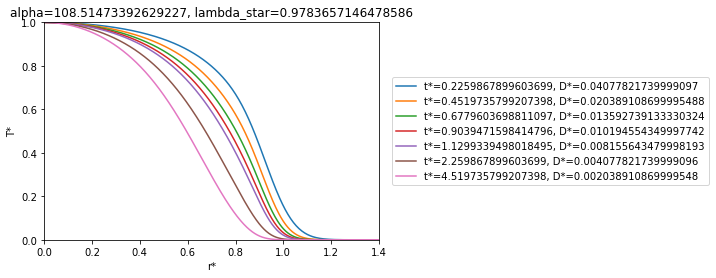

In [3]:
solutionAtYear=np.zeros((1400,7))
x=np.zeros((1400,7))
carray=np.zeros((1,7))
Darray=np.zeros((1,7))
year=[1,2,3,4,5,10,20]

for i in range(7):
    a,b,c,d,e,f=f1(year[i],True)
    solutionAtYear[:,i]=b
    x[:,i]=a
    carray[:,i]=c
    Darray[:,i]=e
    
#Plotting the points  
plt.plot(x[:,0], solutionAtYear[:,0], label='t*='+str(carray[0,0])+', D*='+str(Darray[0,0]))
plt.plot(x[:,1], solutionAtYear[:,1], label='t*='+str(carray[0,1])+', D*='+str(Darray[0,1]))
plt.plot(x[:,2], solutionAtYear[:,2], label='t*='+str(carray[0,2])+', D*='+str(Darray[0,2]))
plt.plot(x[:,3], solutionAtYear[:,3], label='t*='+str(carray[0,3])+', D*='+str(Darray[0,3]))
plt.plot(x[:,4], solutionAtYear[:,4], label='t*='+str(carray[0,4])+', D*='+str(Darray[0,4]))
plt.plot(x[:,5], solutionAtYear[:,5], label='t*='+str(carray[0,5])+', D*='+str(Darray[0,5]))
plt.plot(x[:,6], solutionAtYear[:,6], label='t*='+str(carray[0,6])+', D*='+str(Darray[0,6]))
plt.xlim(0,1.4)
plt.ylim(0,1)
# naming the x axis 
plt.xlabel('r*') 
# naming the y axis 
plt.ylabel('T*') 
# giving a title to my graph 
plt.title('alpha='+str(d)+', lambda_star='+str(f))
plt.legend(bbox_to_anchor=(1.04,0.5), loc="center left", borderaxespad=0)
#plt.savefig("non_heat_loss.png",dpi=1200)
# function to show the plot 
plt.show()

In [4]:
dataFrameForSolution = pd.DataFrame(x) 
#Save to xlsx file
filepath = '1D Vinsome output r.xlsx'
dataFrameForSolution.to_excel(filepath, index=False)

dataFrameForSolution2 = pd.DataFrame(solutionAtYear) 
filepath2 = '1D Vinsome output T.xlsx'
dataFrameForSolution2.to_excel(filepath2, index=False)